In [1]:
import json
import os
import pandas as pd
import numpy as np
from pathlib import Path
import collections
from sklearn.model_selection import train_test_split
from sklearn import metrics

import sys
sys.path.append("../")
from datatools.analyzer import *
from utterance.error_tools import *

from datatools.maneger import DataManager
from datatools.preproc import Preprocessor

In [2]:
corpus_path = "../../corpus/SNLI/"
data_name = "dev_sentence.csv"
data_name = "train_sentence.csv"

In [4]:
df = pd.read_csv(corpus_path+data_name)

In [ ]:
not_contradict_df =  df.query('label == "entailment" | label == "neutral"')
contradict_df = df.query('label == "contradiction"')

In [ ]:
df2 = pd.concat([not_contradict_df, contradict_df.sample(frac=0.3)], axis=0)

In [5]:
from sentence_transformers import SentenceTransformer
from sentence_transformers import models
bert_path = "../../corpus/pretrained/sbert_snli2"
sbert = SentenceTransformer(bert_path)

[13591] 2022-01-21 02:14:59,798 Info sentence_transformers.SentenceTransformer :Load pretrained SentenceTransformer: ../../corpus/pretrained/sbert_snli2
[13591] 2022-01-21 02:15:00,681 Info sentence_transformers.SentenceTransformer :Use pytorch device: cuda


In [6]:
def text2vec(text):
    sentences = []
    if isinstance(text, str):
        sentences = [text]
    elif isinstance(text, list):
        sentences = text
    
    return sbert.encode(sentences)

def text2feature(text):
    vector = text2vec(text)
    diff = np.abs( vector[0] - vector[1] )
    return np.concatenate([vector.flatten(), diff])


def vec2feature(vector):
    diff = np.abs( vector[0] - vector[1] )
    return np.concatenate([vector.flatten(), diff])

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules import loss
import torch.optim as optim
import torch.nn.utils.rnn as rnn

In [8]:
def vec2feature(vector):
    diff = np.abs( vector[0] - vector[1] )
    return np.concatenate([vector.flatten(), diff])

In [9]:
label = ["entailment", "neutral", "contradiction"]
label2id = dict( zip(label, range(len(label))) )

def make_Xy(df):
    X_str = []
    y = []

    for la, pre, hypo in zip(df.label, df.pre, df.hypo):
        if la not in label2id:
            continue
        X_str += [pre, hypo]
        y.append(label2id[la])
    # X_str_all = X_str_all[:250]
    # X_all_str = sum(X_str, [])
    x_length = len(X_str)//2
    X_vec = sbert.encode(X_str).reshape(x_length, 2, -1)
    X = np.array([ vec2feature(vec) for vec in X_vec ])
    # print(X_str_all)
    return torch.from_numpy(X), torch.tensor(y)


In [10]:
X, y = make_Xy(df)

Batches:   0%|          | 0/33313 [00:00<?, ?it/s]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=5, stratify=y
)

In [12]:
class Datasets(torch.utils.data.Dataset):
    def __init__(self, X_data, y_data):
        # self.transform = transform

        self.X_data = X_data
        self.y_data = y_data

        self.datanum = len(X_data)

    def __len__(self):
        return self.datanum

    def __getitem__(self, idx):
        out_X = self.X_data[idx]
        out_y = self.y_data[idx]

        return out_X, out_y

In [13]:
class SNLIModel(nn.Module):
    def __init__(self, embedding_dim, tagset_size):
        # 親クラスのコンストラクタ。決まり文句
        super(SNLIModel, self).__init__()    
        self.embedding_dim = embedding_dim
        self.hid1= embedding_dim*2
        self.hid2 = embedding_dim//2
        self.fc1 = nn.Linear(self.embedding_dim, self.hid1)
        self.fc2 = nn.Linear(self.hid1, self.hid2)
        # LSTMの出力を受け取って全結合してsoftmaxに食わせるための１層のネットワーク
        # self.hidden2tag = nn.Linear(self.hid2+self.fb_dim, tagset_size)
        self.hidden2tag = nn.Linear(self.hid2, tagset_size)
    
    def forward(self, x):
        # fb = x[:, :self.fb_dim]
        y = F.relu(self.fc1(x))
        # y = F.relu(self.fc1(x[]))
        y = F.relu(self.fc2(y))
        y = self.hidden2tag( y )
        y = F.log_softmax(y, dim=1)
        return y

In [14]:
BATCH_SIZE = 64
epoch_ = 400
trainset = Datasets(X_train, y_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)

In [15]:
EMBEDDING_DIM = 768*3
OUTPUT_DIM = 3
print(EMBEDDING_DIM, OUTPUT_DIM)

2304 3


In [16]:
model = SNLIModel(EMBEDDING_DIM, OUTPUT_DIM)
if torch.cuda.is_available():
   model.cuda()
loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005)

In [17]:
losses = []
for epoch in range(epoch_): 
    all_loss = 0
    for data in trainloader:
        # X_t_tensor = torch.tensor(data[0], device='cuda:0')
        X_t_tensor = data[0].cuda()
        # y_t_tensor = torch.tensor(data[1], device='cuda:0')
        y_t_tensor = data[1].cuda()
        optimizer.zero_grad()
        model.zero_grad()
        score_ = model(X_t_tensor)
        loss_ = loss_function(score_, y_t_tensor)
        loss_.backward()
        all_loss += loss_.item()
        optimizer.step()
        del score_
        del loss_
        
    losses.append(all_loss)
    if (epoch+1) % 50 == 0:
        print("epoch", epoch+1, "\t" , "loss", all_loss)
print("done")

epoch 50 	 loss 117.86921394594538
epoch 100 	 loss 60.91275814241726
epoch 150 	 loss 51.86729562044343
epoch 200 	 loss 40.43765252748881
epoch 250 	 loss 32.63210014801841
epoch 300 	 loss 34.79018809754049
epoch 350 	 loss 35.62214689530017


KeyboardInterrupt: 

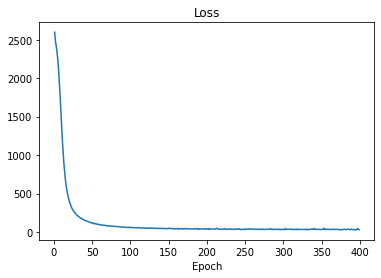

In [18]:
from matplotlib import pyplot as plt
def plot_history(losses):
    fig, ax = plt.subplots()

    epochs = np.arange(1, len(losses) + 1)

    # 損失の推移
    ax.set_title("Loss")
    ax.plot(epochs, losses)
    ax.set_xlabel("Epoch")

    plt.show()
plot_history(losses)

In [19]:
with torch.no_grad():
    X_tensor = torch.tensor(X_test, device='cuda:0').float()
    y_tensor = torch.tensor(y_test, dtype=torch.long, device='cuda:0')
            # 推論
    y_pred= np.array(model(X_tensor).cpu()).argmax(axis=1)

/home/yamada/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/home/yamada/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


RuntimeError: CUDA out of memory. Tried to allocate 2.75 GiB (GPU 0; 6.00 GiB total capacity; 2.03 GiB already allocated; 1.63 GiB free; 2.10 GiB reserved in total by PyTorch)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
print('confusion matrix = \n', confusion_matrix(y_true=y_test, y_pred=y_pred))
print('accuracy = ', accuracy_score(y_true=y_test, y_pred=y_pred))

confusion matrix = 
 [[45702  6780  2293]
 [ 7832 40749  6159]
 [ 2486  5618 46786]]
accuracy =  0.8104193911377391


- そのまま SBERT でもこれくらいは出る

        confusion matrix = 
        [[365  21  44]
        [ 35 331  32]
        [ 53  29 265]]
        accuracy =  0.8178723404255319

In [20]:
model_path = "../models/context/"
model_name = "sbert_snli_dnn3.pickle"
modelM = DataManager(model_path)
modelM.save_data(model_name, model)

success save : ../models/context/sbert_snli_dnn3.pickle
